In [ ]:
!pip install paddlepaddle==3.0.0
!pip install paddleocr==2.10.0

  Using cached paddlepaddle-3.0.0-cp311-cp311-manylinux1_x86_64.whl.metadata (8.9 kB)
Using cached paddlepaddle-3.0.0-cp311-cp311-manylinux1_x86_64.whl (192.8 MB)
  Attempting uninstall: paddlepaddle
    Found existing installation: paddlepaddle 2.5.1
    Uninstalling paddlepaddle-2.5.1:
      Successfully uninstalled paddlepaddle-2.5.1
  Using cached lmdb-1.6.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.1 kB)
  Using cached rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
  Using cached python_docx-1.1.2-py3-none-any.whl.metadata (2.0 kB)
  Using cached fire-0.7.0-py3-none-any.whl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.2 MB/s eta 0:00:00
Using cached lmdb-1.6.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (297 kB)
Using cached python_docx-1.1.2-py3-none-any.whl (244 kB)
Using cached rapidfuzz-3.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Attempting un

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from skimage.morphology import skeletonize
from paddleocr import PaddleOCR

In [ ]:
def grayscale_dan_sobel(citra):
    citra = cv2.imread(citra)
    sobelx = cv2.Sobel(citra, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(citra, cv2.CV_64F, 0, 1, ksize=3)
    gradien = np.sqrt(sobelx**2 + sobely**2)
    sobel = np.uint8(255 * gradien / np.max(gradien))
    gray = cv2.cvtColor(sobel, cv2.COLOR_BGR2GRAY)
    return gray, sobel

def otsu_thresholding(gray):
    histo = cv2.calcHist([gray], [0], None, [256], [0, 256]).ravel()
    total_pixel = gray.shape[0] * gray.shape[1]

    within = []
    for i in range(len(histo)):
        x, y = np.split(histo, [i])  # Split histogram jadi dua kelas: x dan y

        # Bobot
        bobot1 = np.sum(x) / total_pixel
        bobot2 = np.sum(y) / total_pixel

        # Mean
        mean1 = np.sum([inten * f for inten, f in enumerate(x)]) / np.sum(x) if np.sum(x) != 0 else 0
        mean2 = np.sum([(inten + i) * f for inten, f in enumerate(y)]) / np.sum(y) if np.sum(y) != 0 else 0

        # Varians
        var1 = np.sum([(inten - mean1)**2 * f for inten, f in enumerate(x)]) / np.sum(x) if np.sum(x) != 0 else 0
        var2 = np.sum([(inten + i - mean2)**2 * f for inten, f in enumerate(y)]) / np.sum(y) if np.sum(y) != 0 else 0

        # Simpan total variansi dalam list
        within.append(bobot1 * var1 + bobot2 * var2)

    # Ambil threshold terbaik berdasarkan:
    batas_within = np.argmin(within)   # Minimum within-class
    print("Threshold optimal (within):", batas_within)

    # Terapkan threshold ke gambar grayscale
    _, binary = cv2.threshold(gray, batas_within, 255, cv2.THRESH_BINARY)
    return binary

def negasi_Func(citra):
    #negasi= np.bitwise_not(citra)
    negasi= np.zeros_like(citra)
    baris, kolom = citra.shape
    for b in range(baris):
        for k in range(kolom):
            negasi[b,k] = 255 - citra[b,k]
    return negasi

def zhang_suen_thinning(citra):
    skeleton = skeletonize(citra)
    skeleton = skeleton.astype(np.uint8) * 255
    return skeleton

def deteksi_plat_Func(citra):
    gray, sobel = grayscale_dan_sobel(citra)
    binary = otsu_thresholding(gray)
    negated = negasi_Func(binary)
    thinned = zhang_suen_thinning(negated)

    ocr = PaddleOCR(use_angle_cls=True, lang='en')  # lang='ind'
    result = ocr.ocr(thinned, cls=True)

    # Menampilkan hasil per tahap
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(citra), cv2.COLOR_BGR2RGB))
    plt.title('Citra Original')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(gray, cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(sobel, cmap='gray')
    plt.title('Deteksi Tepi Sobel')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.imshow(binary, cmap='gray')
    plt.title('Otsu Thresholding')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.imshow(negated, cmap='gray')
    plt.title('Negasi Otsu Thresholding')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.imshow(thinned, cmap='gray')
    plt.title('Thinned (Zhang-Suen)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    teks_terdeteksi = []
    for line in result[0]:
        plat = line[1][0]
        akurasi = line[1][1]
        print(f"Plat Terdeteksi: {plat} (Akurasi: {akurasi:.2f})")
        teks_terdeteksi.append(plat)

    if not teks_terdeteksi:
        print("Plat tidak terdeteksi.")

    return gray, sobel, binary, negated, thinned, result



Saving image4.jpg to image4 (5).jpg
Threshold optimal (within): 43
download https://paddleocr.bj.bcebos.com/PP-OCRv3/english/en_PP-OCRv3_det_infer.tar to /root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer/en_PP-OCRv3_det_infer.tar


100%|██████████| 3910/3910 [00:17<00:00, 222.53it/s] 


download https://paddleocr.bj.bcebos.com/PP-OCRv4/english/en_PP-OCRv4_rec_infer.tar to /root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer/en_PP-OCRv4_rec_infer.tar


100%|██████████| 10000/10000 [00:17<00:00, 567.82it/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 2138/2138 [00:14<00:00, 146.51it/s]

[2025/05/28 12:38:14] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_l

[2025/05/28 12:38:16] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.5674717426300049
[2025/05/28 12:38:16] ppocr DEBUG: cls num  : 2, elapsed : 0.036289215087890625
[2025/05/28 12:38:16] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16307806968688965


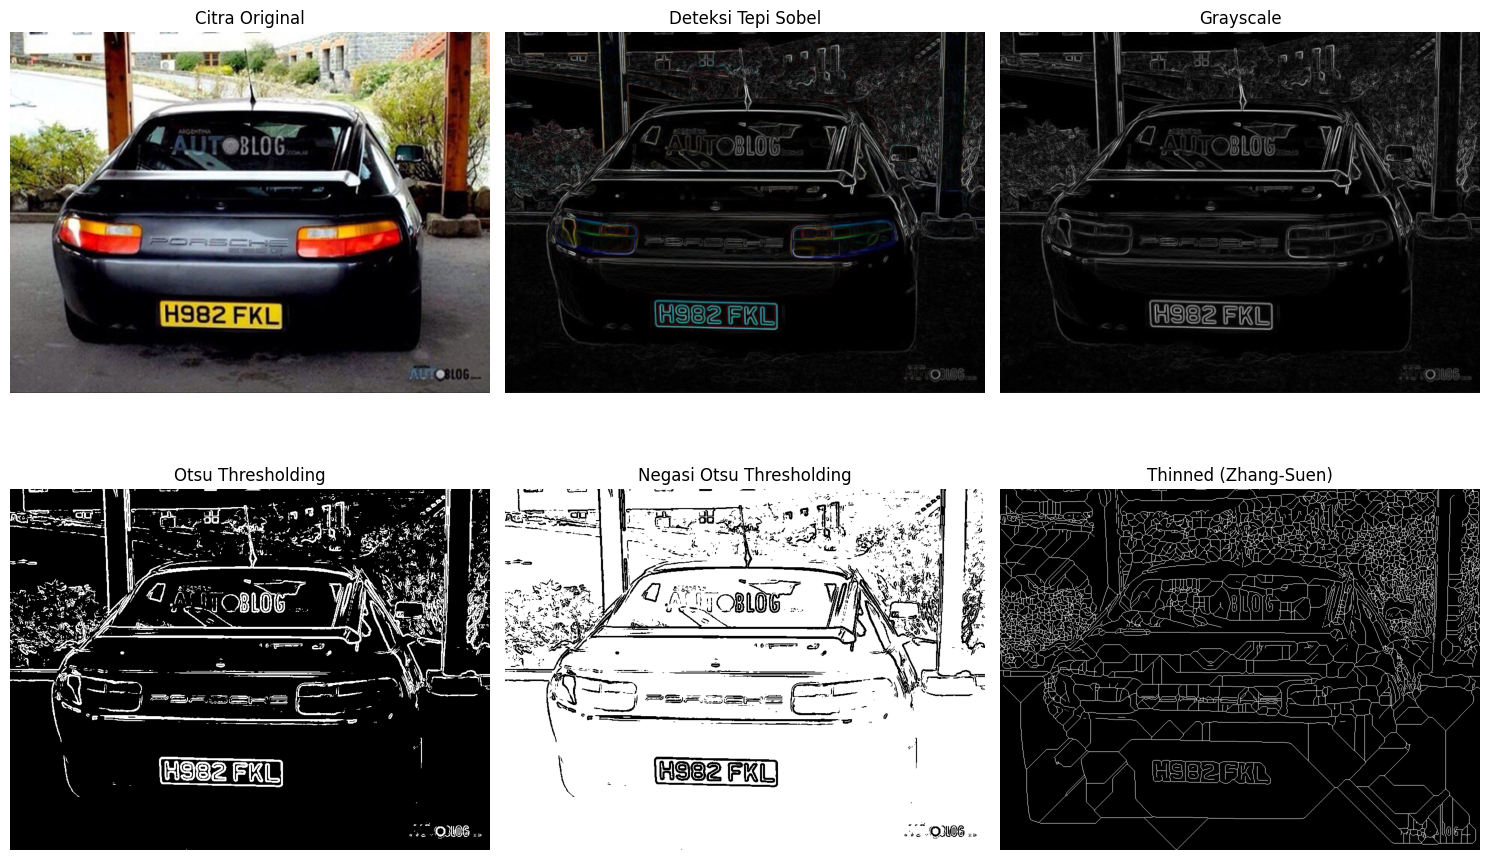

Plat Terdeteksi: H982FkL (Akurasi: 0.85)
Plat Terdeteksi: 106 (Akurasi: 0.74)


In [ ]:
uploaded = files.upload()
citra = next(iter(uploaded))
try:
    gray, sobel, binary, negated, thinned, hasil_ocr = deteksi_plat_Func(citra)
except Exception as e:
    print(f"Error: {e}")
    print("Ada yang salah!.")